In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4idb8ur1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4idb8ur1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 952.5 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [ ]:
import torch
import clip
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [ ]:
import matplotlib.pyplot as plt
from skimage import data
import numpy as np
import seaborn as sns


image_descriptions = {
    "astronaut": data.astronaut(),
    "camera": data.camera(),
    "coffee": data.coffee(),
    "chelsea": data.chelsea(),
    "horse": data.horse()
}

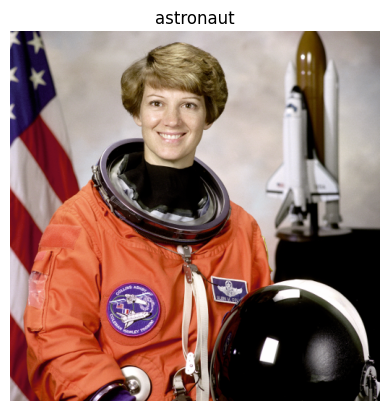

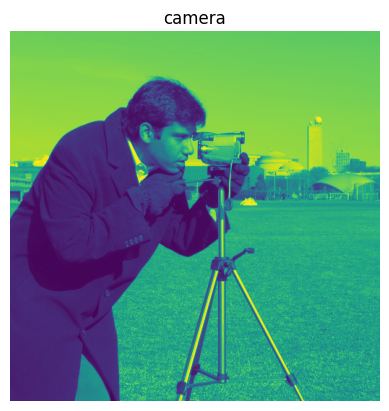

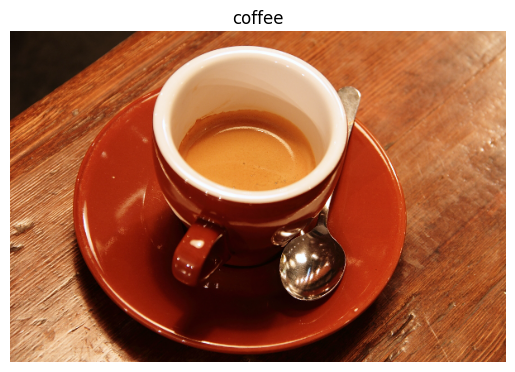

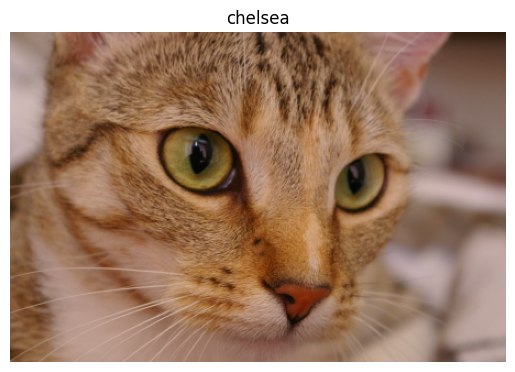

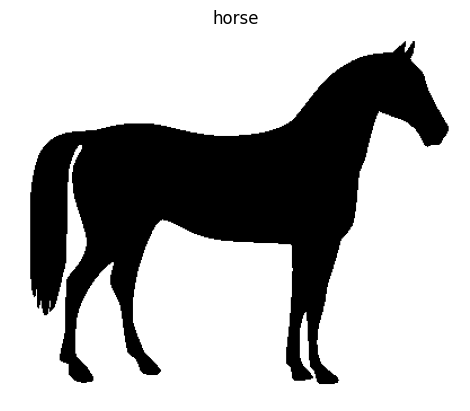

In [ ]:
def preprocess_and_display_images(image_dict):
    for desc, img in image_dict.items():
        img_pil = Image.fromarray(img)
        plt.imshow(img_pil)
        plt.title(desc)
        plt.axis('off')
        plt.show()
preprocess_and_display_images(image_descriptions)

In [ ]:
def encode_images_and_texts(model, processor, image_dict):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    image_features = []
    for desc, img in image_dict.items():
        img_pil = Image.fromarray(img)
        inputs = processor(images=img_pil, return_tensors="pt").to(device)
        with torch.no_grad():
            img_encoded = model.get_image_features(**inputs)
        image_features.append((desc, img_encoded))

    text_descriptions = list(image_dict.keys())
    inputs = processor(text=text_descriptions, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_encoded = model.get_text_features(**inputs)

    return image_features, text_encoded

image_features, text_encoded = encode_images_and_texts(model, processor, image_descriptions)

def normalize_vectors(vectors):
    return vectors / vectors.norm(dim=-1, keepdim=True)

def normalize_features(image_features, text_features):
    normalized_image_features = [(desc, normalize_vectors(img_feature)) for desc, img_feature in image_features]
    normalized_text_features = normalize_vectors(text_features)
    return normalized_image_features, normalized_text_features

normalized_image_features, normalized_text_features = normalize_features(image_features, text_encoded)


in this function we encode the image and their descriptions using our clip modek and eacg image is processed and converted into feature vectors. The text descriptions are also encoded into feature vectors.

Then we normalize those vectors, so that it will be more helpful when we are comparing them and they all will be in a unit norm. It is necessary for the cosine similarity.

In [ ]:
text_encoded

tensor([[ 0.0093,  0.0229, -0.0465,  ..., -0.0553, -0.0637, -0.0163],
        [ 0.0667, -0.1396, -0.3371,  ..., -0.5031,  0.2013, -0.1267],
        [ 0.1593, -0.3300, -0.0572,  ...,  0.1351, -0.3374,  0.0376],
        [ 0.1750, -0.1241,  0.0718,  ...,  0.3921, -0.0176,  0.2577],
        [ 0.0639, -0.1278, -0.1811,  ..., -0.1609, -0.1822,  0.0441]],
       device='cuda:0')

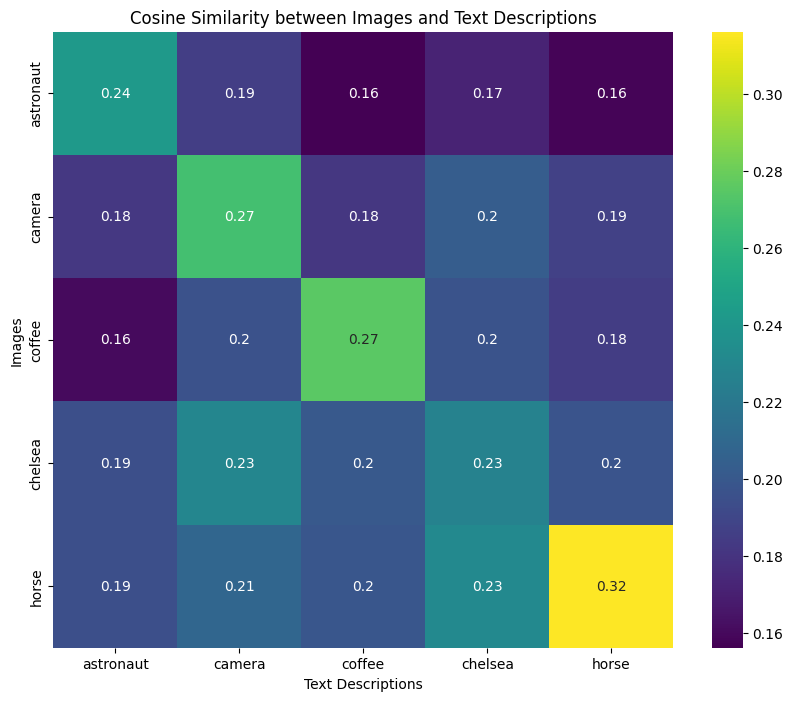

In [ ]:
def compute_similarity(image_features, text_features):
    similarity_matrix = []
    text_features_np = text_features.cpu().numpy()

    for desc, img_feature in image_features:
        img_feature_np = img_feature.cpu().numpy().flatten()
        similarities = np.dot(text_features_np, img_feature_np)
        similarity_matrix.append(similarities)

    return np.array(similarity_matrix)

similarity_matrix = compute_similarity(normalized_image_features, normalized_text_features)

def display_heatmap(similarity_matrix, image_descriptions, text_descriptions):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, xticklabels=text_descriptions, yticklabels=image_descriptions, cmap='viridis', annot=True)
    plt.xlabel("Text Descriptions")
    plt.ylabel("Images")
    plt.title("Cosine Similarity between Images and Text Descriptions")
    plt.show()

text_descriptions = list(image_descriptions.keys())
image_descriptions_list = [desc for desc, _ in normalized_image_features]
display_heatmap(similarity_matrix, image_descriptions_list, text_descriptions)

We compute the cosine similarity between each image and the text features. Teh result is the heatmap similarity matrix where each element represents the similarity scote between image and a description.

In [ ]:
cifar100_classes = [
    'apple', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak tree', 'orange', 'orchid', 'otter', 'palm tree', 'pear', 'pickup truck', 'pine tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
    'streetcar', 'sunflower', 'sweet pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train',
    'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow tree', 'wolf', 'woman', 'worm'
]

inputs = processor(text=cifar100_classes, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_features = model.get_text_features(**inputs)

def encode_images(model, processor, image_dict):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    image_features = []
    for desc, img in image_dict.items():
        img_pil = Image.fromarray(img)
        inputs = processor(images=img_pil, return_tensors="pt").to(device)
        with torch.no_grad():
            img_encoded = model.get_image_features(**inputs)
        image_features.append((desc, img_encoded))

    return image_features

image_features = encode_images(model, processor, image_descriptions)

def compute_similarity_and_probabilities(image_features, text_features):
    probabilities = []
    text_features_np = text_features.cpu().numpy()

    for desc, img_feature in image_features:
        img_feature_np = img_feature.cpu().numpy().flatten()
        similarities = np.dot(text_features_np, img_feature_np)
        probs = torch.softmax(torch.tensor(similarities), dim=0).numpy()
        probabilities.append((desc, probs))

    return probabilities

probabilities = compute_similarity_and_probabilities(normalized_image_features, normalized_text_features)

def display_top_matches(probabilities, text_descriptions, top_k=5):
  for desc, probs in probabilities:
        top_indices = np.argsort(probs)[-top_k:][::-1]
        top_classes = [text_descriptions[i] for i in top_indices]
        top_probs = [probs[i] for i in top_indices]

        print(f"Top {top_k} matches for image '{desc}':")
        for i, (cls, prob) in enumerate(zip(top_classes, top_probs)):
            print(f"  {i+1}. {cls} - {prob:.4f}")
        print()

display_top_matches(probabilities, cifar100_classes)

Top 5 matches for image 'astronaut':
  1. woman - 0.0105
  2. orange - 0.0104
  3. can - 0.0104
  4. plate - 0.0103
  5. bridge - 0.0103

Top 5 matches for image 'camera':
  1. man - 0.0104
  2. television - 0.0103
  3. boy - 0.0103
  4. can - 0.0103
  5. telephone - 0.0103

Top 5 matches for image 'coffee':
  1. cup - 0.0109
  2. orange - 0.0105
  3. tulip - 0.0105
  4. table - 0.0104
  5. plate - 0.0103

Top 5 matches for image 'chelsea':
  1. sweet pepper - 0.0104
  2. mouse - 0.0103
  3. tiger - 0.0103
  4. squirrel - 0.0103
  5. pear - 0.0103

Top 5 matches for image 'horse':
  1. plate - 0.0105
  2. camel - 0.0105
  3. cattle - 0.0104
  4. dolphin - 0.0103
  5. kangaroo - 0.0103



We use the function that computes the similarity probabilities between image and text feature vectors using softmax function and the result is a list of probabilities which says how likely each text description matches an image.

As we can see, the model is correctly assigning the top match for each of the pictures. In the picture with the astrinaut there's clearly a woman and in the picture called camera there's a man that's holding it. For the picture of a coffee there's a cup and so on. For the horse the model suggested plate, but there was a misunderstanding, in my opinion.
